_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [198]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders


# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index.

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer



In [200]:
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)
# YOUR CODE HERE


In [201]:
def wrangle(fm_path, tv_path = None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path,
                         parse_dates= 'game_date').set_index('game_date'), pd.read_csv(fm_pathparse_dates= 'game_date').set_index('game_date'))
  else:
    df = pd.read_csv(fm_path,
                parse_dates= ['game_date']).set_index('game_date')
  df.drop(columns = 'player_name', inplace = True)
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
   if df[col].nunique() > cutoff]
  df.drop(columns = drop_cols, inplace = True)
  dupe = [col for col in df.head(100).T.duplicated().index
  if df.head(100).T.duplicated()[col]]
  df.drop(columns = dupe, inplace = True)

  return df

df = wrangle(url)



In [202]:
shot_made_coor =df[['loc_x','loc_y', 'shot_made_flag']]
shot_made_coor.value_counts()
df['sweet_spots'] = np.where(((df['loc_x'] == 0) & ((df['loc_y'] == 1) | (df['loc_y'] == 0))), 1, 0)
(df['sweet_spots'] == 1).value_counts()
(df[['sweet_spots', 'shot_made_flag']] ==1).value_counts()

sweet_spots  shot_made_flag
False        False             7305
             True              6525
True         True                76
             False               52
Name: count, dtype: int64

In [203]:
df.columns

Index(['game_id', 'game_event_id', 'period', 'minutes_remaining',
       'seconds_remaining', 'action_type', 'shot_type', 'shot_zone_basic',
       'shot_zone_area', 'shot_zone_range', 'shot_distance', 'loc_x', 'loc_y',
       'shot_made_flag', 'htm', 'vtm', 'season_type',
       'scoremargin_before_shot', 'sweet_spots'],
      dtype='object')

**Task 1 Testing**

In [204]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [205]:
"""T2. Create new feature"""

# YOUR CODE HERE
df.columns.nunique()
(((df[['shot_zone_area','shot_zone_basic', 'shot_made_flag']]).value_counts()).head(50)).sort_index().sort_values()
df['center_shots_made'] = np.where((((df['shot_zone_area'] == 'Center(C)') & (df['shot_zone_basic']== 'Restricted Area') & df['shot_made_flag']==1)),0,1)

**Task 2 Test**

In [206]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [207]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
target = 'shot_made_flag'
X = df.drop(columns = target)
y = df[target]

**Task 3 Test**

In [208]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.'

**Task 4:** Divide your dataset into training, validation, and test sets.

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [209]:
'''T4. Create training and val'''
'''T4. Create training and val'''
# YOUR CODE HERE
X_train = X[((X.index.year >= 2009) & (X.index.year <= 2016) & (X.index.month >= 10)) |
            ((X.index.year >= 2010) & (X.index.year <= 2017) & (X.index.month <= 6))]
y_train = y[y.index.isin(X_train.index.unique())]


X_val = X[((X.index.year == 2017) & (X.index.month >= 10)) |
          ((X.index.year == 2018) & (X.index.month <= 6))]
y_val = y[y.index.isin(X_val.index.unique())]


X_test = X[((X.index.year == 2018) & (X.index.month >= 10)) |
          ((X.index.year == 2019) & (X.index.month <= 6))]
y_test = y[y.index.isin(X_test.index.unique())]

**Test 4**

In [210]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [211]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = df['shot_made_flag'].value_counts(normalize = True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5270812437311936


**Task 5 Testing**

In [212]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [213]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE
model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(strategy = 'mean'),
                      RandomForestClassifier(max_depth = 5, n_estimators = 25, n_jobs = -1, random_state = 42)
                      )
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup Shot                             4
Jump Bank Shot                         5
Driving Layup Shot                     6
Reverse Layup Shot                     7
Running Jump Shot                      8
Floating Jump...
SAC    14
CLE    15
MIA    16
MIL    17
CHI    18
DEN    19
NJN    20
NOH    21
CHA    22
OKC    23
DAL    24
UTA    25
ATL    26
PHI    27
DET    28
TOR    29
NYK    30
BKN    31
NOP    32
NaN    -2
dtype: int64},
                                         {'col': 'season_type',
                                          'data_type': dtype('O'),
                                          'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=25, n_jobs=-1,
                                        random_state=42))])

**Task 6 Testing**

In [214]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [215]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = accuracy_score(y_train, model.predict(X_train))
val_acc = accuracy_score(y_val, model.predict(X_val))
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.7215955238696868
Validation Accuracy Score: 0.6738013698630136


**Task 7 Test**

In [216]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`.
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [217]:
'''T8. Tune model.'''

# YOUR CODE HERE
model_g = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        RandomForestClassifier(n_jobs = -1, random_state = 42))
model_g.fit(X_train,y_train)

param_grid = {'simpleimputer__strategy': ['mean', 'median'],
              'randomforestclassifier__n_estimators':range(25,125,25),
              'randomforestclassifier__max_depth':range(5,25,5) }

model_gs = GridSearchCV(model_g,
           param_grid = param_grid,
             n_jobs = -1,
             cv= None,
             verbose = 2)
model_gs.fit(X_train, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['action_type',
                                                             'shot_type',
                                                             'shot_zone_basic',
                                                             'shot_zone_area',
                                                             'shot_zone_range',
                                                             'htm', 'vtm',
                                                             'season_type'],
                                                       mapping=[{'col': 'action_type',
                                                                 'data_type': dtype('O'),
                                                                 'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup Shot                             4
Jump Bank Shot                         5
Driving Layup Shot                     6
Reverse Layup Shot                     7
Runni...
                                                                 'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 25, 5),
                         'randomforestclassifier__n_estimators': range(25, 125, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=2)

In [218]:
y_pred = model_gs.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)
print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.6840257460503218


In [219]:
model_gs.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__n_estimators': 25,
 'simpleimputer__strategy': 'mean'}

**Task 8 Testing**

In [220]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

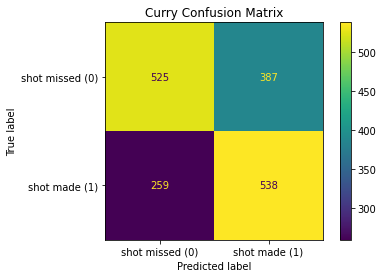

In [221]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
instructor_precision = 538 / (538 + 387)
instructor_recall = 538 / (538 + 259)


print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [222]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**.

This task will not be autograded - but it is part of completing the challenge.

In [223]:
'''T10. Plot Confusion Matrix'''
# YOUR CODE HERE


'T10. Plot Confusion Matrix'